# Build and Train Model

In [1]:
import math
import os
from glob import glob
from skimage import io
from random import sample 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Load Data

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('Data_Entry_2017_updated.csv')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
39674,00010367_000.png,No Finding,0,10367,25,M,PA,2594,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
59190,00014646_005.png,No Finding,5,14646,56,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
35921,00009470_000.png,No Finding,0,9470,3,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
12616,00003300_005.png,Infiltration|Mass|Nodule,5,3300,47,M,AP,2500,2048,0.171,...,0,0,1,1,0,1,0,0,0,Non-pneumonia
102108,00027199_001.png,No Finding,1,27199,20,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-pneumonia


## Create training and testing data

In [3]:
def create_splits(df, test_size=0.2):
    
    train_df, valid_df = train_test_split(df, test_size=test_size, stratify=df['Pneumonia'])
    
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]


    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,3*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]

    return train_df, valid_df

train_df, valid_df = create_splits(all_xray_df)
train_df.shape, valid_df.shape

((2288, 28), (1144, 28))

In [4]:
def image_augmentation(data_type):
    if data_type == 'train':
        return ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    if data_type == 'valid':
        return ImageDataGenerator(rescale=1. / 255.0)
    
train_idg = image_augmentation('train')
val_idg = image_augmentation('valid')

In [5]:
def make_gen(idg, df, batch_size, IMG_SIZE=(224, 224)):
    
    return idg.flow_from_dataframe(dataframe=df, 
                                             directory=None, 
                                             x_col='Path',
                                             y_col='Class',
                                             class_mode='binary',
                                             target_size=IMG_SIZE, 
                                             batch_size=batch_size)

train_gen = make_gen(train_idg, train_df, 30)
val_gen = make_gen(val_idg, valid_df, 20)   

Found 2288 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


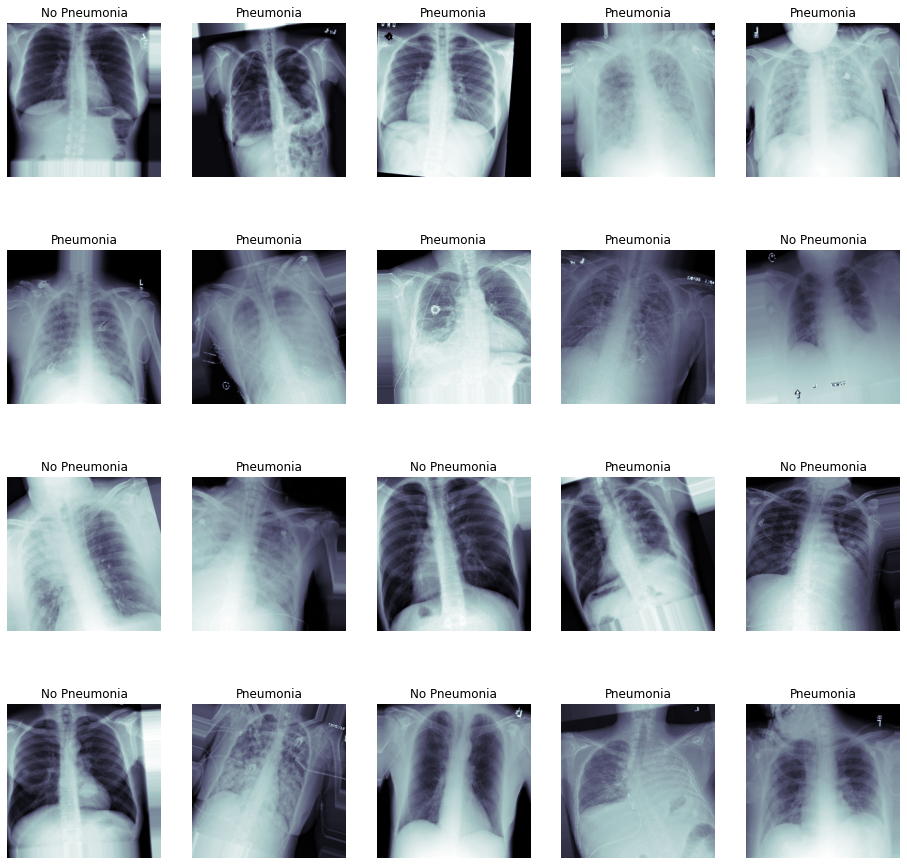

In [6]:
t_x, t_y = next(train_gen)
valX, valY = next(val_gen)

fig, m_axs = plt.subplots(4, 5, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build Model

In [7]:
def load_pretrained_model():

    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

vgg_model = load_pretrained_model()

In [8]:
def build_model():
    
    model = Sequential()
    model.add(vgg_model)
#     model.add(Flatten()) 
#     model.add(Dropout(0.5))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  
    return model
model = build_model()

In [9]:
weight_path="{}_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=3, 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.382,
#                               patience=2, 
#                               min_lr=0.000001, 
#                               verbose=1, 
#                               cooldown=1)

def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.618
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

callbacks_list = [checkpoint, early, LearningRateScheduler(step_decay, verbose=1)] #reduce_lr

### Start training! 

In [10]:
optimizer = Adam(lr=1e-4) # RMSprop(lr=1e-5) 
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
77/77 [==============================] - 62s 801ms/step - loss: 0.6855 - binary_accuracy: 0.5542 - val_loss: 0.7003 - val_binary_accuracy: 0.6000
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
77/77 [==============================] - 55s 713ms/step - loss: 0.6705 - binary_accuracy: 0.5935 - val_loss: 0.6799 - val_binary_accuracy: 0.6000
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
77/77 [==============================] - 58s 752ms/step - loss: 0.6675 - binary_accuracy: 0.5966 - val_loss: 0.6682 - val_binary_accuracy: 0.6000

Epoch 00003: val_loss improved from inf to 0.66822, saving model to xray_class_model.best.hdf5
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
77/77 [==============================] - 58s 747ms/step - loss: 0.6636 - binary_accuracy: 0.6036 - val_loss: 0.6627 - val_binary_accuracy: 0.5500


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [11]:
model.load_weights(weight_path)
val_gen = make_gen(val_idg, valid_df, 1144)
valX, valY = val_gen.next()
pred_Y = model.predict(valX)

Found 1144 validated image filenames belonging to 2 classes.


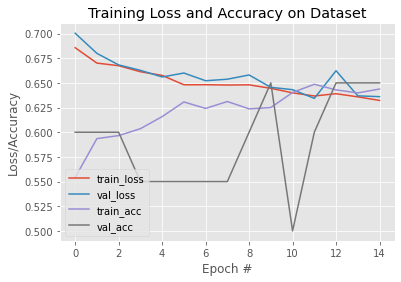

In [12]:
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
plot_history(history)

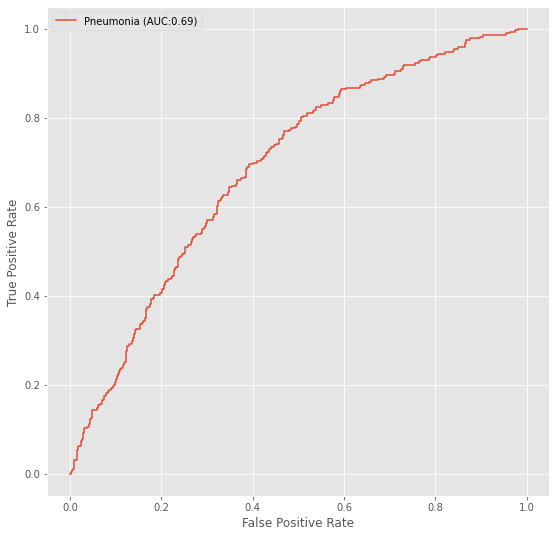

In [13]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
plot_auc(valY, pred_Y)

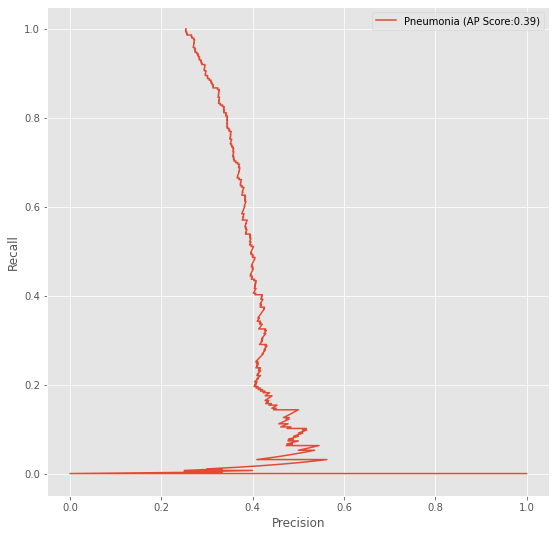

In [14]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')
    
plot_pr(valY, pred_Y)

In [15]:
def calc_f1(t_y, p_y, beta):
    prec, recall, thresholds = precision_recall_curve(t_y, p_y)
    return (1+beta**2)*(prec*recall)/(beta**2*prec+recall), prec, recall, thresholds

f_beta, prec, recall, thresholds = calc_f1(valY, pred_Y, 0.382)
thresholds = np.append(thresholds, thresholds[-1] + (thresholds[-1] - thresholds[-2]))
metric_df = pd.DataFrame({'f_beta':f_beta, 'prec':prec, 'recall':recall, 'thresholds':thresholds})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


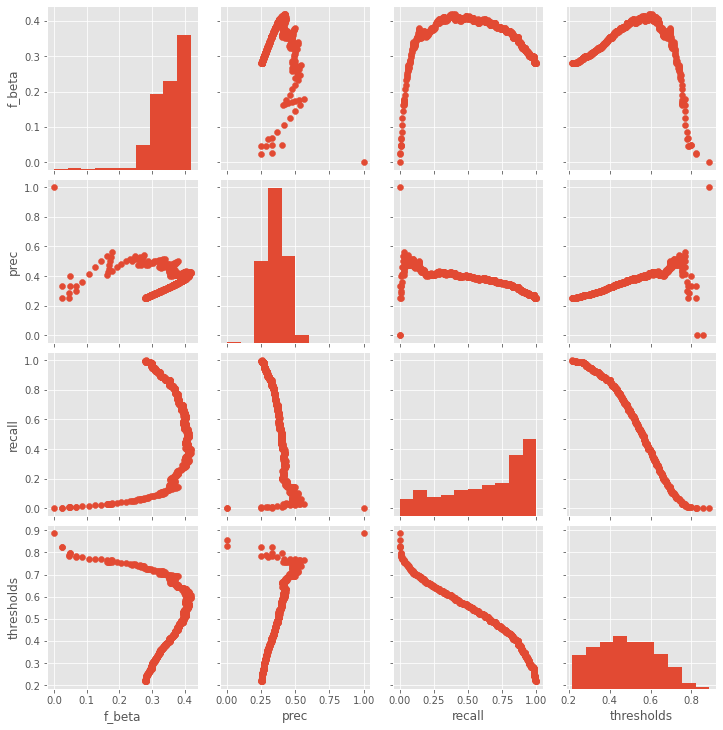

In [16]:
# assess how changing the threshold changes the precision, recall, and F1
g = sns.PairGrid(data = metric_df, vars = ['f_beta', 'prec', 'recall', 'thresholds'])
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);

In [17]:
print('max f_beta:', max(f_beta))
threshold = thresholds[f_beta.argmax()]
print('threshold corresponding to max f_beta:', threshold)

max f_beta: 0.41885724726778134
threshold corresponding to max f_beta: 0.8272922


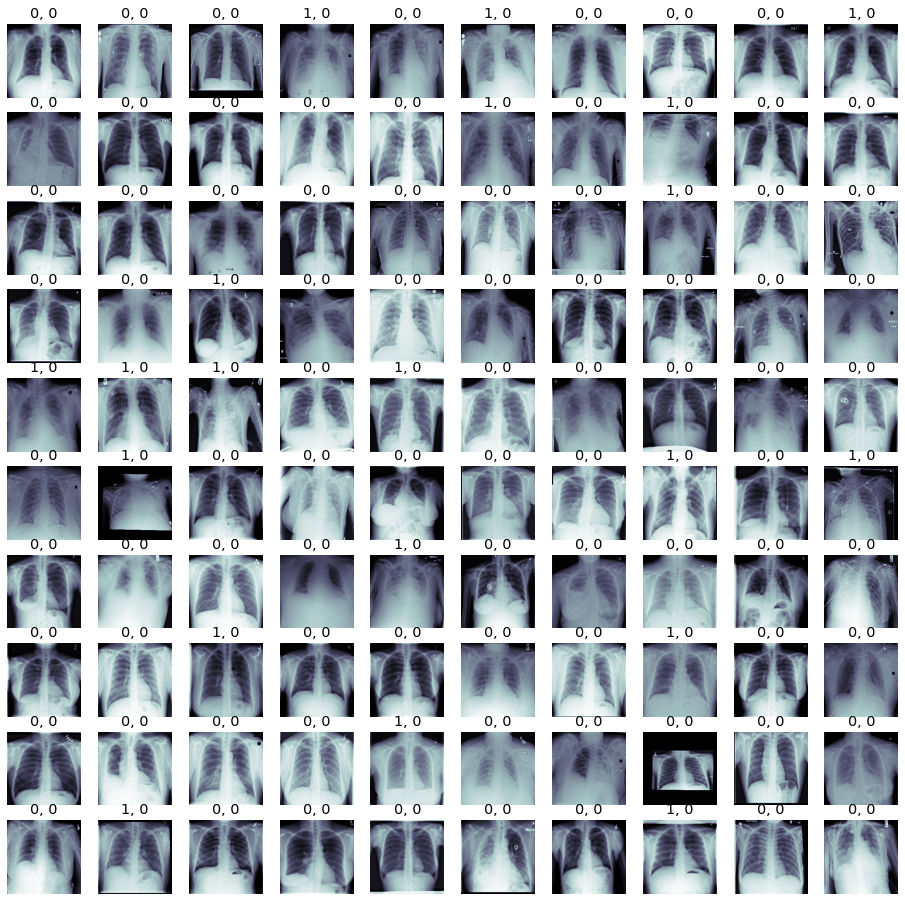

In [18]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [19]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)